<a href="https://colab.research.google.com/github/BenxiaHu/DeepLearning/blob/main/pytorch_1D_CNN_KFold_07032024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network


Dependencies:
* torch: 0.1.11
* matplotlib

# step0: import python packages

In [22]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
from numpy import array
import pandas as pd
import numpy as np
from numpy import argmax
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import requests
from torch.nn import LogSoftmax
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

torch.manual_seed(1)



# step1: import data

In [23]:
seqid="https://raw.githubusercontent.com/BenxiaHu/DeepLearning/main/K562_MPRA_Silencers.txt"
#print(seqid)
seqid = pd.read_csv(seqid,header=0,sep="\t")
seqid["peakid"] = seqid['chr'] +":"+ seqid["start"].astype(str) +"-"+ seqid["end"].astype(str)
print(seqid)
seqid = seqid[["peakid","silencer"]]
#print(seqid)

fastaid="https://raw.githubusercontent.com/BenxiaHu/DeepLearning/main/K562_MPRA_Silencers.fasta"
fastaid = pd.read_table(fastaid,header=None,sep="\t")
#print(fastaid)
fastaid.rename(columns={0:"peakid",1:"fasta"},inplace=True)

result = pd.merge(fastaid, seqid, how='inner', on=['peakid', 'peakid'])

result[["fasta"]] = result[["fasta"]].apply(lambda x: x.astype(str).str.upper())

result = result[["fasta","silencer"]]

#label="https://raw.githubusercontent.com/BenxiaHu/DeepLearning/main/labels.txt"
#label = pd.read_table(labelid,header=None)
input = result[["fasta"]]
print(input.shape)
label = result[["silencer"]]


DNA = np.zeros(shape=(len(input),len(input["fasta"][0]),4))
labelid = np.zeros(shape=(len(input),))
#print(DNA.shape)
#print(labelid.shape)

for i in range(input.shape[0]):
    seq_array = array(list(input["fasta"][i]))
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse_output=False)
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    DNA[i] = onehot_encoded_seq
    #DNA[i] = onehot_encoded_seq.reshape(4,len(onehot_encoded_seq))
    labelid[i] = label["silencer"][i]

DNA = torch.tensor(DNA)
DNA = DNA.permute(0, 2, 1)
labelid =  torch.tensor(labelid)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    DNA = DNA.to("cuda:0")
    labelid =  labelid.to("cuda:0")
print(DNA.is_cuda)


        chr      start        end  silencer                     peakid
0      chr1  113408175  113408375         1   chr1:113408175-113408375
1     chr10    6107715    6107915         1      chr10:6107715-6107915
2     chr10   15538675   15538875         1    chr10:15538675-15538875
3     chr11  114339756  114339956         1  chr11:114339756-114339956
4     chr17   41121376   41121576         1    chr17:41121376-41121576
...     ...        ...        ...       ...                        ...
7227   chrX   93929096   93929296         0     chrX:93929096-93929296
7228   chrX  101946395  101946595         0   chrX:101946395-101946595
7229   chrX  130859105  130859305         0   chrX:130859105-130859305
7230   chrX  131424075  131424275         0   chrX:131424075-131424275
7231   chrX  141256436  141256636         0   chrX:141256436-141256636

[7232 rows x 5 columns]
(2000, 1)
False


# step2: build the 1D-CNN model

In [50]:
class CNN(nn.Module):
    def __init__(self, sequence_length=200, n_genomic_features=2):
        super(CNN, self).__init__()
        conv_kernel_size = 4
        pool_kernel_size = 2
        self.conv_net = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=4, out_channels=128, kernel_size=conv_kernel_size, padding=0),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_kernel_size),
            nn.Dropout(p=0.2),

            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=conv_kernel_size, padding=0),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_kernel_size),
            nn.Dropout(p=0.2),

            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=conv_kernel_size, padding=0),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_kernel_size),
            nn.Dropout(p=0.2),

            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=conv_kernel_size, padding=0),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_kernel_size),
            nn.Dropout(p=0.4))

        reduce_by = conv_kernel_size - 1
        pool_kernel_size = float(pool_kernel_size)

        self.n_channels = int(
                np.floor(
                    (np.floor(
                        (np.floor(
                            (np.floor(
                             (sequence_length - reduce_by) / pool_kernel_size)
                            - reduce_by) / pool_kernel_size)
                            - reduce_by) / pool_kernel_size)
                            - reduce_by) / pool_kernel_size))

        self.classifier = nn.Sequential(
            nn.Linear(16 * self.n_channels, n_genomic_features),
            nn.ReLU(inplace=True),
            nn.Linear(n_genomic_features, n_genomic_features),
            nn.Sigmoid())

    def forward(self, x):
        """Forward propagation of a batch.
        """
        out = self.conv_net(x)
        reshape_out = out.view(out.size(0), 16 * self.n_channels)
        predict = self.classifier(reshape_out)
        return predict



# step3 running the CNN model

In [51]:
# training and testing
cnn = CNN()
LR = 0.001
optimizer = torch.optim.SGD(cnn.parameters(), lr=LR,momentum=0.9,weight_decay=1e-3)   # optimize all cnn parameters
optimizer.zero_grad()           # clear gradients for this training step
loss_func = nn.BCELoss()                  # the target label is not one-hotted
#print(cnn)  # net architecture
EPOCH = 2000              # train the training data n times, to save time, we just train 1 epoch

train_losses = {}
totalcorrectTest = {}
totalcorrect = {}
BATCH_SIZE = 64
NUM_FOLDS = 10

all_labels = {}
all_probs = {}

skf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=123)

for fold, (train_index, test_index)  in enumerate(skf.split(DNA, labelid)):
    x_train, x_test = DNA[train_index], DNA[test_index]
    y_train, y_test = labelid[train_index], labelid[test_index]
    torch_dataset = Data.TensorDataset(x_train, y_train)
    train_loader = Data.DataLoader(dataset= torch_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    torch_dataset2 = Data.TensorDataset(x_test, y_test)
    test_loader = Data.DataLoader(dataset=torch_dataset2, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
    train_losses[str(fold)] = []
    totalcorrect[str(fold)] = []
    totalcorrectTest[str(fold)] = []
    all_labels[str(fold)] = []
    all_probs[str(fold)] = []
    for epoch in range(EPOCH):
        cnn.train()
        running_loss = 0.0
        correctTest = 0
        totalTest = 0
        j = 0
        for i, (b_x, b_y) in enumerate(train_loader):  # gives batch data, normalize x when iterate train_loader
            b_x = Variable(b_x).type(torch.FloatTensor)
            b_y = Variable(b_y).type(torch.LongTensor)
            b_y = b_y.type(torch.FloatTensor)
            optimizer.zero_grad()           # clear gradients for this training step
            output = cnn(b_x)               # cnn output
            preds, predsid = torch.max(output,1)
            totalTest += b_y.size(0)
            loss = loss_func(preds, b_y)   # cross entropy loss
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients
            running_loss += loss.item()
            j+=1
            correctTest += (predsid == b_y).sum().item()
        totalcorrectTest[str(fold)].append(100 * correctTest // totalTest)
        if(epoch % 10==0):
            print(f'the loss on each epoch: {epoch}, loss: {running_loss/j}')
            print(f'the test accuracy on each epoch: {epoch}, test accuracy: {100 * correctTest // totalTest}')
        train_losses[str(fold)].append(running_loss / j)  # Append the running loss to the list for this fold

    #total = total.to("cuda:0")
    # since we're not training, we don't need to calculate the gradients for our outputs
        total = 0
        correct = 0
        cnn.eval()
        with torch.no_grad():
            for i, (b_x, b_y) in enumerate(test_loader):
                b_x = Variable(b_x).type(torch.FloatTensor)
                # calculate outputs by running the network
                outputs = cnn(b_x)
                # the class with the highest energy is what we choose as prediction
                preds, predsid = torch.max(outputs,1)
                total += b_y.size(0)
                #predsid = predsid.to("cuda:0")
                predsid = predsid.to("cpu")
                correct += (predsid == b_y).sum().item()
                all_labels[str(fold)].append(b_y.tolist())
                all_probs[str(fold)].append(preds.tolist())
        totalcorrect[str(fold)].append(100 * correct // total)
        if(epoch % 10==0):
            print(f'the validation accuracy on each epoch: {epoch}, validation accuracy: {100 * correct // total}')
        if((100 * correctTest // totalTest) > 95):
            break
#print(f'Accuracy of the network on the 100 test : {100 * correct // total} %')
print('Finished Training')

# Let’s quickly save our trained model:
#!pwd
#torch.save(cnn.state_dict(), "./content")



the loss on each epoch: 0, loss: 0.7212875932455063
the test accuracy on each epoch: 0, test accuracy: 49
the validation accuracy on each epoch: 0, validation accuracy: 53
the loss on each epoch: 10, loss: 0.6477638483047485
the test accuracy on each epoch: 10, test accuracy: 49
the validation accuracy on each epoch: 10, validation accuracy: 54
the loss on each epoch: 20, loss: 0.6150897443294525
the test accuracy on each epoch: 20, test accuracy: 50
the validation accuracy on each epoch: 20, validation accuracy: 52
the loss on each epoch: 30, loss: 0.572259464434215
the test accuracy on each epoch: 30, test accuracy: 51
the validation accuracy on each epoch: 30, validation accuracy: 53
the loss on each epoch: 40, loss: 0.5560174786618778
the test accuracy on each epoch: 40, test accuracy: 52
the validation accuracy on each epoch: 40, validation accuracy: 53
the loss on each epoch: 50, loss: 0.522740435387407
the test accuracy on each epoch: 50, test accuracy: 54
the validation accurac

KeyboardInterrupt: 

# make plots

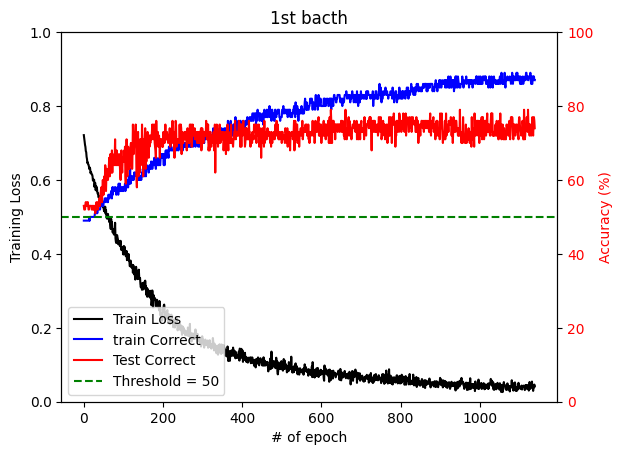

In [52]:
fig = plt.figure()
ax1 = plt.subplot(1, 1, 1)

# Plotting the train losses on the first y-axis
ax1.plot(train_losses['0'], color='black', label='Train Loss')
ax1.set_xlabel("# of epoch")
ax1.set_ylabel("Training Loss", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 1.00)

# totalcorrectTest
# Creating a second y-axis to plot the test correct values
ax2 = ax1.twinx()
ax2.plot(totalcorrectTest['0'], color='blue', label='train Correct')
ax2.plot(totalcorrect['0'], color='red', label='Test Correct')
ax2.set_ylabel("Accuracy (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100)
ax2.axhline(y=50, color='green', linestyle='--', label='Threshold = 50')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
ax1.set_title("1st bacth")
#plt.legend(loc="center")
# Showing the plot
plt.show()



# make plot

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(1, 1, 1)

# Plotting the train losses on the first y-axis
ax1.plot(train_losses['1'], color='black', label='Train Loss')
ax1.set_xlabel("# of epoch")
ax1.set_ylabel("Training Loss", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Creating a second y-axis to plot the test correct values
ax2 = ax1.twinx()
ax2.plot(totalcorrect['1'], color='red', label='Test Correct')
ax2.set_ylabel("Test Accuracy (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=50, color='green', linestyle='--', label='Threshold = 50')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center')
ax1.set_title("2nd bacth")
plt.show()

# make 2nd plot

In [ ]:
# Plot ROC curve
# Calculate ROC curve and AUC
all_labelsID = np.concatenate([np.array(all_labels['0']).flatten(),
                              np.array(all_labels['1']).flatten(),
                              np.array(all_labels['2']).flatten(),
                              np.array(all_labels['3']).flatten(),
                              np.array(all_labels['4']).flatten(),
                              np.array(all_labels['5']).flatten(),
                              np.array(all_labels['6']).flatten(),
                              np.array(all_labels['7']).flatten(),
                              np.array(all_labels['8']).flatten(),
                              np.array(all_labels['9']).flatten()])

all_probsID = np.concatenate([np.array(all_probs['0']).flatten(),
                              np.array(all_probs['1']).flatten(),
                              np.array(all_probs['2']).flatten(),
                              np.array(all_probs['3']).flatten(),
                              np.array(all_probs['4']).flatten(),
                              np.array(all_probs['5']).flatten(),
                              np.array(all_probs['6']).flatten(),
                              np.array(all_probs['7']).flatten(),
                              np.array(all_probs['8']).flatten(),
                              np.array(all_probs['9']).flatten()])
fpr, tpr, thresholds = roc_curve(all_labelsID.tolist(), all_probsID.tolist())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (1st batch)')
plt.legend(loc="lower right")
plt.show()


# make 3rd plot

In [ ]:
# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(all_labelsID.tolist(), all_probsID.tolist())
average_precision = average_precision_score(all_labelsID.tolist(), all_probsID.tolist())
plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2, label='PRC curve (area = %0.4f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# test the model

In [ ]:


net = CNN() #0.001
net.load_state_dict(torch.load("./content"))
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, (b_x, b_y) in enumerate(test_loader):
        b_x = Variable(b_x).type(torch.FloatTensor)
        #print(b_x.shape)
        #b_y = b_y.type(torch.LongTensor)
        # calculate outputs by running the network
        outputs = net(b_x)
        # the class with the highest energy is what we choose as prediction
        preds, predsid = torch.max(outputs,1)
        total += b_y.size(0)
        correct += (predsid == b_y).sum().item()

print(f'Accuracy of the network on the 10000 test : {100 * correct // total} %')
